In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
from sklearn.manifold import TSNE
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os

os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:(using euc only for now since its faster)

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [3]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    
    return preds
    

In [4]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [5]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,nn=20):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)]) #appends the index of the hit with highest tanimoto
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)])#appends the index of the hit with highest tanimoto
    return tanimotos, pred
    

In [16]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

In [17]:
# function to extract the query and subject molecule, its legend(class_tanimoto_with the hit), can also return tanis
def pick_hit_mols(hits_dict, 
              train_df,test_df,group=None,
              return_tanimoto=False,k=2,filterby='inchikey14'): #if group == [cf_class], set filterby to 'cf_class'
    query_mols = []
    hits_mols = []
    tanimoto = []
    query_labels = []
    hit_labels = []
    for query_index, subject_index in  hits_dict.items():
    
    
        query_smile = test_df['smiles'].iloc[query_index]
        query_class = test_df['cf_class'].iloc[query_index]
        query_inchi = test_df['inchikey14'].iloc[query_index]
        
        if group:
            
            if filterby == 'cf_class':
                if query_class not in group:
                    continue
            else:
                if query_inchi not in group:
                    continue
    
        if type(query_class) == float:
            query_class = 'NAN'
            #classes = [f'Query:\t{query_class}',]
    
        query_labels.append(f'Query_{query_index}: {query_class}')#else
    
        query = Chem.MolFromSmiles(query_smile)
    
        subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
        subject = Chem.MolFromSmiles(subject_smile)
        cl = train_df['cf_class'].iloc[subject_index[0][0]]
        if type(cl) == float:
            cl = 'NAN'
        subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
        #print(query_class,subject_class)
        hit_labels.append(subject_class)
        query_mols.append(query)
        hits_mols.append(subject) #to expand later to include top 5 hits
        tanimoto.append(subject_index[0][1])
    
    
    if return_tanimoto:
        return [query_mols, hits_mols],[query_labels,hit_labels],tanimoto
    else:
        return [query_mols, hits_mols],[query_labels,hit_labels]

In [18]:
#plot the distribution of the three top tanimotos from the three metrics
def plot_distribution(values, title,
                      savefig=False,
                      legends=None,xlab=None,
                    ylab=None,
                      palette = None,
                     fig_path=None
                     ):
    
    for i, val in enumerate(values):
        if palette:
            ax=sns.kdeplot(x=val, color=palette[i],shade=False)
            
        else:
            ax=sns.kdeplot(x=val,shade=True)
    
    plt.legend(labels=legends, loc='center left', fontsize=12)
    plt.xlabel(xlab, fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.title(label=title, fontsize=15)
    
    if savefig and fig_path:
        plt.savefig(fig_path,\
               transparent=False,bbox_inches = 'tight')
    plt.show()

In [119]:
def mcs_score(query_smile, target_smile, threshold=0.9):
    
    query_mol = Chem.MolFromSmiles(query_smile)
    target_mol = Chem.MolFromSmiles(target_smile)# will be a list later
    mols = [query_mol, target_mol]
    mcs = rdFMCS.FindMCS(mols,
                    completeRingsOnly=True,#should the ring be complete?  
                    ringMatchesRingOnly=False, #should ring atoms match elsewhere?
                    timeout=60, #timeout in seconds
                    threshold=threshold,
                    )
    shared_atoms = mcs.numAtoms/query_mol.GetNumAtoms() # what fraction of atoms is shared between the query and hit
    shared_bonds = mcs.numBonds/query_mol.GetNumBonds() # what fraction of bonds is shared between the query and hit
    
    score = (shared_atoms+shared_bonds)/2
    
    return round(score, 4)

### Load df with sdl z transformations

In [20]:
# paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle','./max3_sdl_dims_10_test_df_with_z.pickle']
# train_df = Files(paths[0]).load_pickle()
# test_df = Files(paths[1]).load_pickle()
# hits_sdl = Files('./max3_sdl_hits_dims_10.pickle').load_pickle()
# hits_cca = Files('./max3_cca_hits_dims_10.pickle').load_pickle()


#testing cca and sdl_768

paths = ['./max3_sdl_cca_dims_15_train_df_with_z.pickle',
        './max3_sdl_cca_dims_15_test_df_with_z.pickle',
        './max3_sdl_cca_dims_15_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()
val_df.head()


hits_sdl = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_hits_test_df').load_pickle()


In [11]:
len(hits_sdl)

8290

#### Calculate the predictions from each of the loaded models (different batch sizes)

In [148]:
%%time

dims = 25
size = 1000
metric = 'euc' 

euc_all = []
hits = []
tanis = []
methods = ['sdl_128','sdl_256','sdl_384','sdl_512','sdl_640', 'sdl_768'] #models

for method in methods:
    dist = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df.head(size),dims=dims,\
                        method=method, metric='euc')
    
    tan, hit = get_tanimotos(dist,subject_df=Models.train_df,\
                                query_df=Models.test_df.head(size),\
                                    metric='euc')
    euc_all.append(dist)
    hits.append(hit)
    tanis.append(tan)




[16:38:19] WARNING: not removing hydrogen atom without neighbors


Wall time: 26min 36s


In [40]:
%%time
#testing cca and sdl768 15 dims
metrics = ['euc', 'corr', 'cos']
# dists = []
# hits = []
# tanis = []

dims = 15

paths_distances = ['./sdl_768_15_dims/sdl_768_15_dims_euc_test_df',
                   './sdl_768_15_dims_corr_test_df',
                  './sdl_768_15_dims_cos_test_df'] # to write as generate

paths_tanis = ['./sdl_768_15_dims/sdl_768_15_dims_euc_tanis_test_df',
                   './sdl_768_15_dims/sdl_768_15_dims_corr_tanis_test_df',
                  './sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df'] # to write as generate

paths_hits = ['./sdl_768_15_dims/sdl_768_15_dims_euc_hits_test_df',
                   './sdl_768_15_dims/sdl_768_15_dims_corr_hits_test_df',
                  './sdl_768_15_dims/sdl_768_15_dims_cos_hits_test_df'] # to write as generate

for i, metric in enumerate(metrics):
    dist = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl_768', metric=metric)
    
    tan, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=test_df,\
                                    metric=metric)
    #dists.append(dist)
    #hits.append(hit)
    #tanis.append(tan)
    Files(paths_distances[i]).write_to_file(dist)
    Files(paths_tanis[i]).write_to_file(tan)
    Files(paths_hits[i]).write_to_file(hits)
    print(f'{metrics[i]} COMPLETE')
    

    
    

[00:05:13] WARNING: not removing hydrogen atom without neighbors


euc COMPLETE


[03:06:32] WARNING: not removing hydrogen atom without neighbors


MemoryError: 

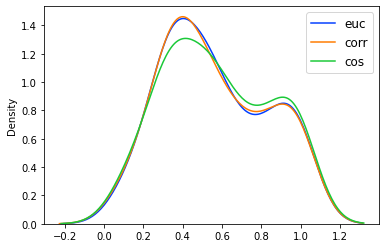

In [37]:
metrics = ['euc', 'corr', 'cos']
palette = sns.color_palette("bright")
for i, tan in enumerate(tanis):
    ax=sns.kdeplot(x=tan,color = palette[i],shade=False)
plt.legend(labels=metrics, loc='upper right', fontsize=12)
plt.show()

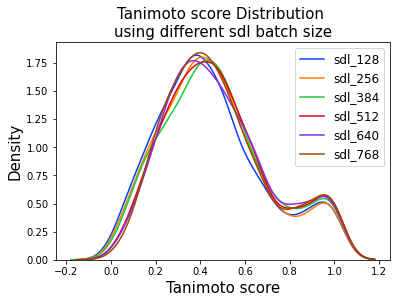

In [149]:
#plot the distribution of the three top tanimotos from the three metrics

palette = sns.color_palette("bright") 
           
for i, tan in enumerate(tanis):
    ax=sns.kdeplot(x=tan,color = palette[i],shade=False)
plt.legend(labels=methods, loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different sdl batch size', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [33]:
 %%time
test_sdl_corr_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='corr')

#tanimotos, and the top hit  using corr  
test_sdl_corr_dim_10_tanimotos, hits_sdl_corr_dim_10 = get_tanimotos(test_sdl_corr_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='corr')


[02:43:24] WARNING: not removing hydrogen atom without neighbors
[02:44:16] WARNING: not removing hydrogen atom without neighbors
[02:44:22] WARNING: not removing hydrogen atom without neighbors
[02:45:43] WARNING: not removing hydrogen atom without neighbors
[02:45:52] WARNING: not removing hydrogen atom without neighbors
[02:46:33] WARNING: not removing hydrogen atom without neighbors
[02:46:39] WARNING: not removing hydrogen atom without neighbors
[02:46:41] WARNING: not removing hydrogen atom without neighbors
[02:47:13] WARNING: not removing hydrogen atom without neighbors
[02:47:36] WARNING: not removing hydrogen atom without neighbors
[02:47:49] WARNING: not removing hydrogen atom without neighbors
[02:48:28] WARNING: not removing hydrogen atom without neighbors
[02:48:32] WARNING: not removing hydrogen atom without neighbors
[02:49:04] WARNING: not removing hydrogen atom without neighbors
[02:49:59] WARNING: not removing hydrogen atom without neighbors
[02:50:36] WARNING: not r

Wall time: 2h 51min 20s


In [ ]:

%%time
test_sdl_cos_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='cos')
#tanimotos, and the top hit  using cos  
test_sdl_cos_dim_10_tanimotos, hits_sdl_cos_dim_10 = get_tanimotos(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='cos')


In [35]:
#random tanimotos
random_tanimotos = random_tanimoto(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                       query_df=test_df)


In [27]:
paths = ['./max3_sdl_tanimoto_dims_10.pickle', 
         './max3_cca_tanimoto_dims_10.pickle',
        ]
         #'./max3_sdl_cos_tanimoto_dims_10_20_nn.pickle']

sdl_dims10_tanis = Files(paths[0]).load_pickle()
cca_dims10_tanis = Files(paths[1]).load_pickle()
len(cca_dims10_tanis)


path_cos = './max3_cca_euc_dims_10.pickle'

sdl_cos_10 = Files(path_cos).load_pickle()

paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
        './max3_sdl_dims_10_test_df_with_z.pickle']
train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()

In [28]:
#random tanimotos
random_tanimotos = random_tanimoto(sdl_cos_10,\
                                       subject_df=train_df,\
                                       query_df=test_df)
len(sdl_cos_10)

8290

In [47]:
len(random_tanimotos)

8290

In [44]:
df = pd.DataFrame({'DeepCCA_Tanimoto':[x for x in sdl_dims10_tanis],
                  'CCA_Tanimoto': [x for x in cca_dims10_tanis],
                   'Random_Tanimoto': [x for x in random_tanimotos]
                  })

In [45]:
df.head()

,DeepCCA_Tanimoto,CCA_Tanimoto,Random_Tanimoto
0,0.3717,0.3434,0.0674
1,0.5107,0.4432,0.2623
2,0.8632,0.8521,0.3890
3,0.7112,0.6175,0.2364
4,0.5995,0.5764,0.3471


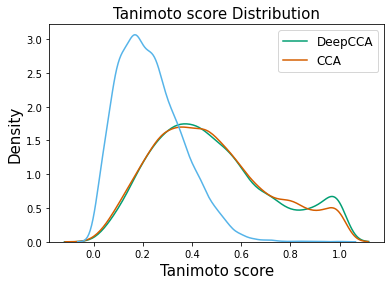

In [49]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [#sns.color_palette("colorblind")[4], #DCCA
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          sns.color_palette("colorblind")[9]] #random
dist_list = [sdl_dims10_tanis,
             cca_dims10_tanis,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=[#'DCCA',
                   'DeepCCA',
                   'CCA',
                   #'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

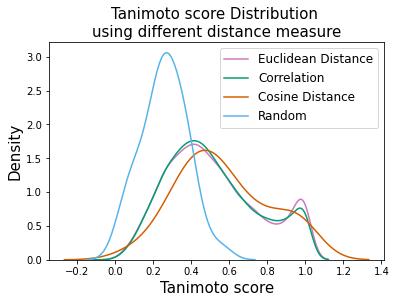

In [44]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #euc
           sns.color_palette("colorblind")[2], #corr
           sns.color_palette("colorblind")[3], #cos
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_sdl_euc_dim_10_tanimotos,
             test_sdl_corr_dim_10_tanimotos,
             test_sdl_cos_dim_10_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['Euclidean Distance',
                   'Correlation',
                   'Cosine Distance',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different distance measure', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [37]:
dists= [test_sdl_euc_dim_10,test_sdl_corr_dim_10,test_sdl_cos_dim_10]
hits = [hits_sdl_euc_dim_10,hits_sdl_corr_dim_10,hits_sdl_cos_dim_10]
tanis = [test_sdl_euc_dim_10_tanimotos,test_sdl_corr_dim_10_tanimotos,test_sdl_cos_dim_10_tanimotos]




In [43]:
len(dists[0])

8290

In [105]:
# paths = ['./max3_sdl_euc_dims_10.pickle', './max3_sdl_corr_dims_10.pickle','./max3_sdl_cos_dims_10.pickle']

# for euc, path in zip(dists,paths):
#     Files(path).write_to_file(euc)

In [ ]:
# paths = ['./max3_sdl_euc_hits_dims_10_20_nn.pickle', './max3_sdl_hits_corr_dims_10_20_nn.pickle','./max3_sdl_hits_cos_dims_10_20_nn.pickle']

# for hit, path in zip(hits,paths):
#     Files(path).write_to_file(hit)

In [40]:
# paths = ['./max3_sdl_euc_tanimoto_dims_10_20_nn.pickle', './max3_sdl_corr_tanimoto_dims_10_20_nn.pickle','./max3_sdl_cos_tanimoto_dims_10_20_nn.pickle']

# for tan, path in zip(tanis,paths):
#     Files(path).write_to_file(tan)

In [67]:
%%time

dims = 10
#n=50
nn=10
metric = 'euc'
#predict sdl euc
test_sdl_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='sdl', metric=metric)
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)
# dcca
test_dcca_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='dcca', metric=metric)
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)

#cca
test_cca_euc = predict(subject_df=Models.train_df,\
                       query_df=Models.test_df,dims=dims,\
                       method='cca',metric=metric)
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric)

#random tanimotos
random_tanimotos = random_tanimoto(test_cca_euc, \
                                       subject_df=Models.train_df,\
                                       query_df=Models.test_df)



[00:14:20] WARNING: not removing hydrogen atom without neighbors
[00:14:21] WARNING: not removing hydrogen atom without neighbors
[00:15:00] WARNING: not removing hydrogen atom without neighbors
[00:15:22] WARNING: not removing hydrogen atom without neighbors
[00:15:25] WARNING: not removing hydrogen atom without neighbors
[00:16:36] WARNING: not removing hydrogen atom without neighbors
[00:17:02] WARNING: not removing hydrogen atom without neighbors
[00:17:58] WARNING: not removing hydrogen atom without neighbors
[00:43:48] WARNING: not removing hydrogen atom without neighbors


Wall time: 1h 29min 22s


In [150]:
%%time
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl_20_nn = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:05:08] WARNING: not removing hydrogen atom without neighbors
[11:05:17] WARNING: not removing hydrogen atom without neighbors
[11:07:04] WARNING: not removing hydrogen atom without neighbors
[11:08:00] WARNING: not removing hydrogen atom without neighbors
[11:08:02] WARNING: not removing hydrogen atom without neighbors
[11:08:42] WARNING: not removing hydrogen atom without neighbors
[11:09:28] WARNING: not removing hydrogen atom without neighbors
[11:10:16] WARNING: not removing hydrogen atom without neighbors
[11:10:22] WARNING: not removing hydrogen atom without neighbors
[11:12:56] WARNING: not removing hydrogen atom without neighbors
[11:13:52] WARNING: not removing hydrogen atom without neighbors
[11:15:57] WARNING: not removing hydrogen atom without neighbors
[11:18:35] WARNING: not removing hydrogen atom without neighbors


Wall time: 14min 30s


In [154]:
%%time
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca_20_nn = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric, nn=20)

Wall time: 12min 51s


In [156]:
%%time
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca_20_nn = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:58:57] WARNING: not removing hydrogen atom without neighbors


Wall time: 12min 56s


In [ ]:
eucs = [test_sdl_euc,test_dcca_euc,test_cca_euc]
hits = [hits_sdl_20_nn,hits_dcca_20_nn,hits_cca_20_nn]
tanis = [test_sdl_euc_tanimotos,test_dcca_euc_tanimotos,test_cca_euc_tanimotos]




In [69]:
paths = ['./max3_sdl_euc_dims_10.pickle', './max3_dcca_euc_dims_10.pickle','./max3_cca_euc_dims_10.pickle']

for euc, path in zip(eucs,paths):
    Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_hits_dims_10_20_nn.pickle', './max3_dcca_hits_dims_10_20_nn.pickle','./max3_cca_hits_dims_10_20_nn.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [ ]:
paths = ['./max3_sdl_tanimoto_dims_10_20_nn.pickle', './max3_dcca_tanimoto_dims_10_20_nn.pickle','./max3_cca_tanimoto_dims_10_20_nn.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

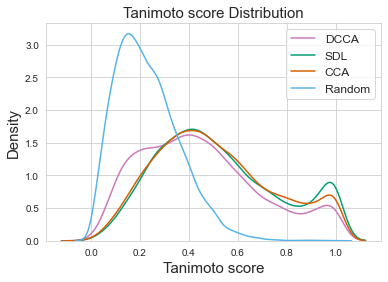

In [157]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #DCCA
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_dcca_euc_tanimotos,
             test_sdl_euc_tanimotos,
             test_cca_euc_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['DCCA',
                   'SDL',
                   'CCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

#### Draw Random predicted molecule

In [4]:
#os.listdir()

In [20]:
# load hits this was with nn=100
paths = ['./max3_sdl_hits.pickle','./max3_dcca_hits.pickle','./max3_cca_hits.pickle']
hits_sdl = Files(paths[0]).load_pickle()
hits_dcca = Files(paths[1]).load_pickle()
hits_cca = Files(paths[2]).load_pickle()

In [22]:
#load dfs
paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()


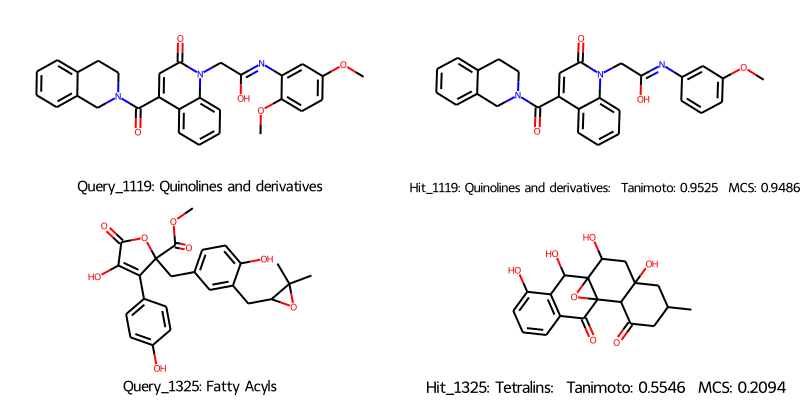

In [129]:
#randomly pick a query
keys = random.choices(list(hits_sdl.keys()),k=2)
subset_hits = {key: hits_sdl[key] for key in keys}

#draw the random queries plus their hits
sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)

mols = []
for query, hit in zip(sdl_random_mols[0], sdl_random_mols[1]):
    mols.append(query)
    mols.append(hit)
legends = []
for query_label, hit_label in zip(sdl_random_legends[0], 
                                  sdl_random_legends[1]):
    legends.append(query_label)
    legends.append(hit_label)
    
len(sdl_random_mols[0])
Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(400,200),
                                returnPNG=True)


### Test how the model performs with classes appearing less than 2 times

In [122]:
# select classes appearing < 2 times in the train dataset
train_rare_classes = train_df.groupby('cf_class').filter(lambda x : 2 >= len(x))
train_rare_classes.shape

(79, 14)

In [123]:
# select classes appearing < 2 times in the test dataset
test_rare_classes = test_df.\
loc[test_df['cf_class'].isin([x for x in \
                                         train_rare_classes['cf_class']])]

test_rare_classes.shape

(33, 14)

In [124]:
test_rare_classes = random.choices([x for x in test_rare_classes['cf_class']],k=10)

In [11]:
# sdl rare mols
sdl_rare_mols, sdl_rare_legends, sdl_rare_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          group=test_rare_classes,
                              return_tanimoto=True,filterby='cf_class')
Draw.MolsToGridImage(sdl_rare_mols,
                        molsPerRow=2, 
                        legends = sdl_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

NameError: name 'test_rare_classes' is not defined

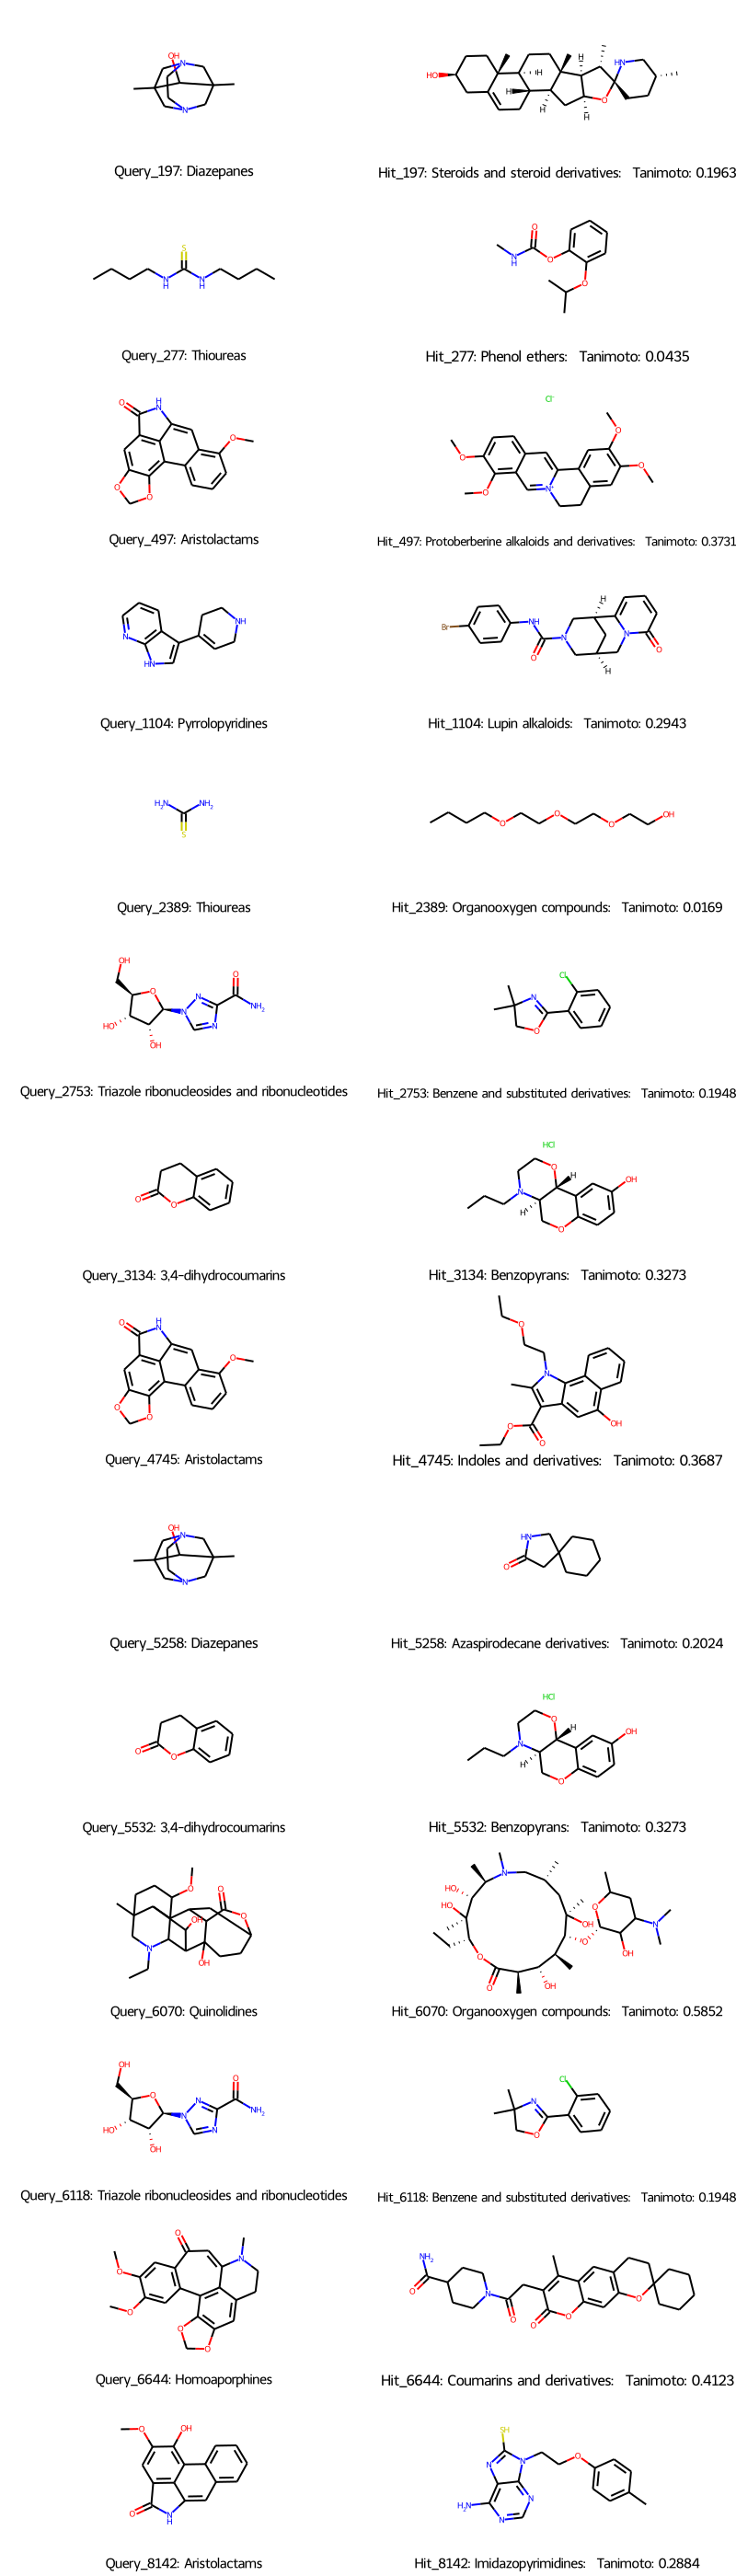

In [126]:
# cca rare mols
cca_rare_mols, cca_rare_legends, cca_rare_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(cca_rare_mols,
                        molsPerRow=2, 
                        legends = cca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

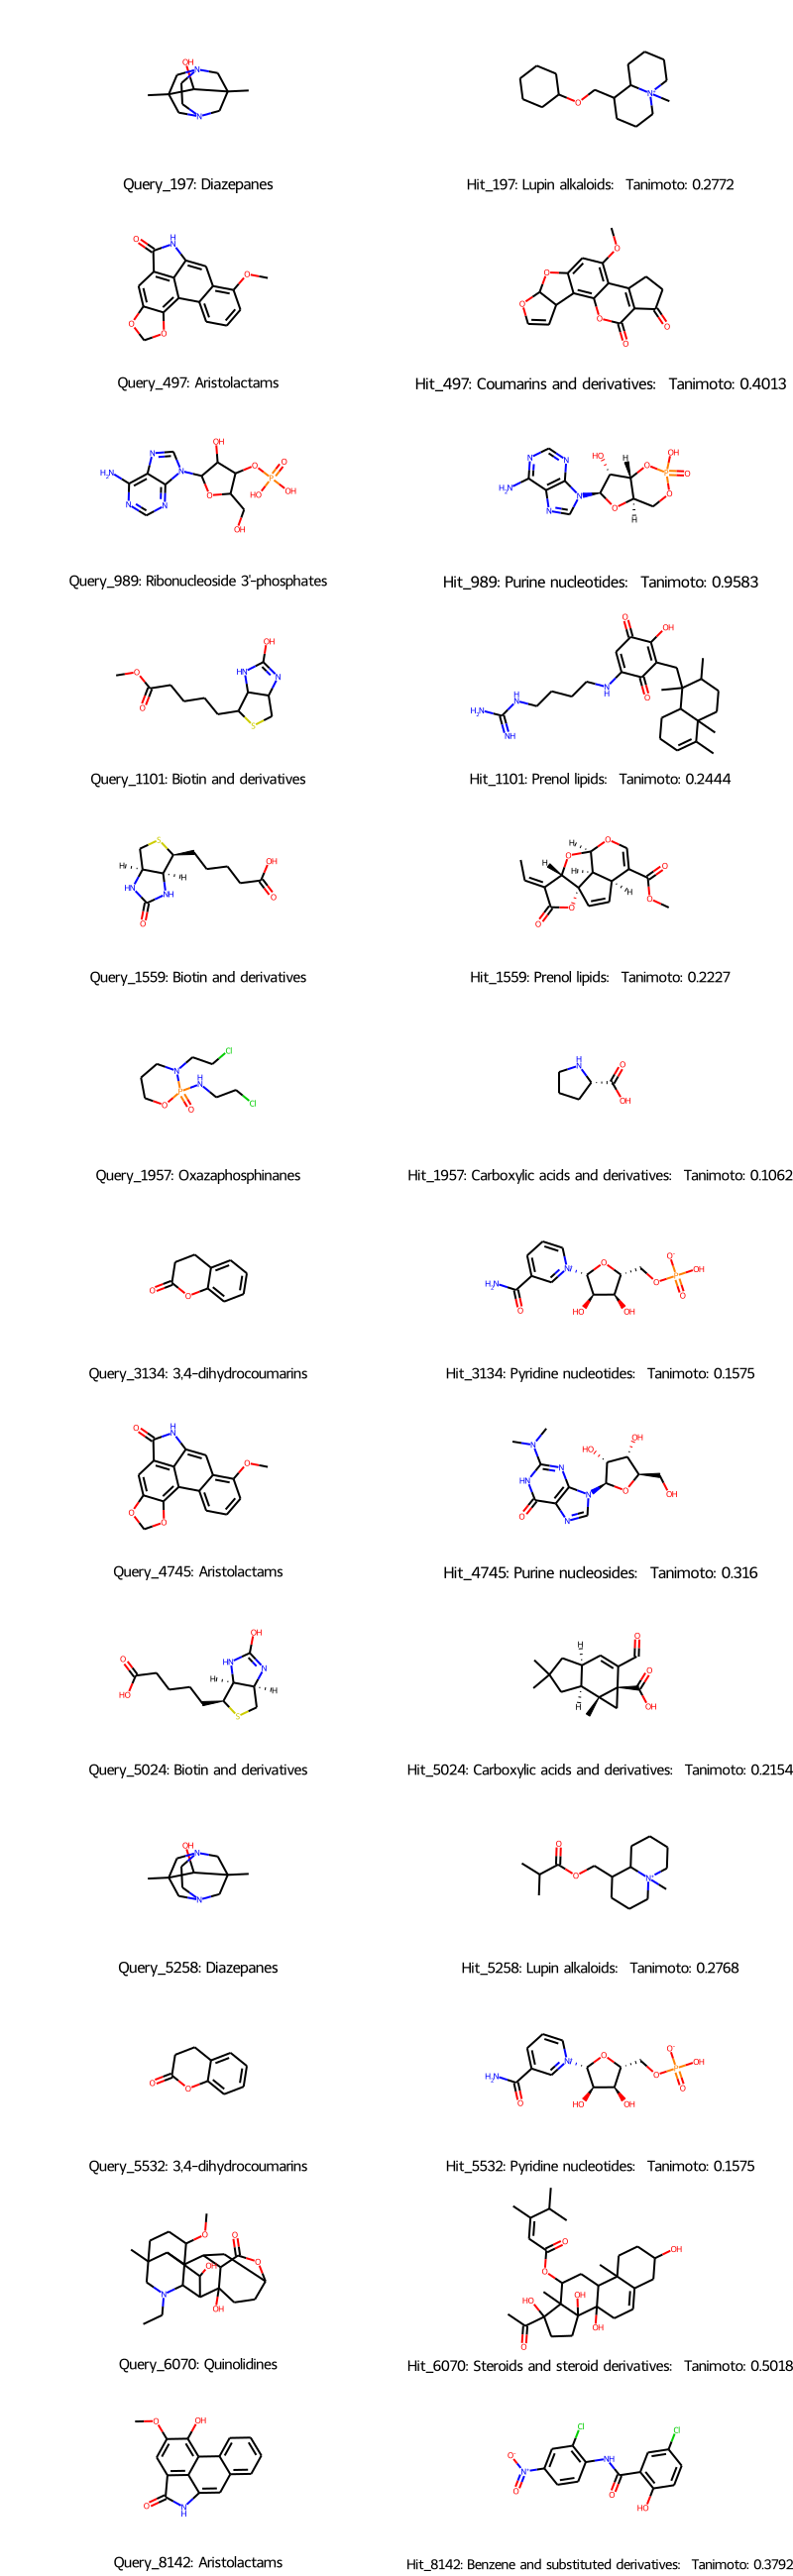

In [185]:
# dcca rare mols
dcca_rare_mols, dcca_rare_legends, dcca_rare_tanis = pick_hit_mols(hits_dcca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(dcca_rare_mols,
                        molsPerRow=2, 
                        legends = dcca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

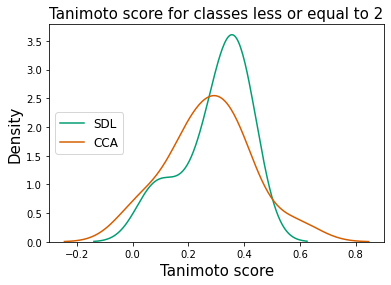

In [128]:
#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]]
tanis = [sdl_rare_tanis,cca_rare_tanis]
legends = ['SDL', 'CCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for classes less or equal to 2'
fig_path = './rare_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                  palette = palette[1:3],
                     fig_path=fig_path,
                     savefig=True)

#### Investigate if the models will always return true hits if it is in the subject dataset(database)

In [130]:
# select inchikey14 occuring both in test(query) and train(subject) 
common_inchikeys =train_df.groupby('inchikey14').filter(lambda x : len(x)>=2)
common_inchikeys.shape

(20773, 12)

In [131]:
common_chi_list = [x for x in common_inchikeys['inchikey14']]

In [132]:
test_common_ichi= test_df.\
loc[test_df['inchikey14'].isin(common_chi_list)]
test_common_ichi.shape

test_common_list = [x for x in test_common_ichi['inchikey14']]#,k=10)# sample a few to draw structures

In [ ]:
# sdl common mols (not common anymore if you hash out group=)
sdl_mols, sdl_mol_legends, sdl_mol_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(sdl_common_mols,
#                         molsPerRow=2, 
#                         legends = sdl_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [ ]:
len(sdl_mol_tanis)

In [133]:
# cca common mols
cca_common_mols, cca_common_legends, cca_common_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(cca_common_mols,
#                         molsPerRow=2, 
#                         legends = cca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [134]:
len(cca_common_tanis)

8290

In [122]:
# dcca common mols
dcca_common_mols, dcca_common_legends, dcca_common_tanis = pick_hit_mols(hits_dcca,Models.train_df,Models.test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(dcca_common_mols,
#                         molsPerRow=2, 
#                         legends = dcca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [105]:
len(sdl_common_tanis)

2746

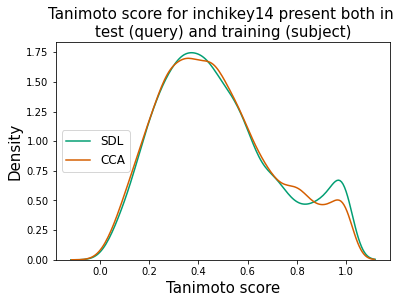

In [135]:
tanis = [#dcca_common_tanis,
         sdl_common_tanis,
         cca_common_tanis]
legends = [#'DCCA', 
           'SDL',
           'CCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for inchikey14 present both in \ntest (query) and training (subject)'
fig_path = './common_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                      palette = palette[1:3],
                     fig_path=fig_path,
                     savefig=False)

In [28]:
#apply this to tanis
df = pd.DataFrame({'eucledian':[x for x in tanis_euc],
                  'correlation':[x for x in tanis_corr],
                  'cosine':[x for x in tanis_cos]
                 })

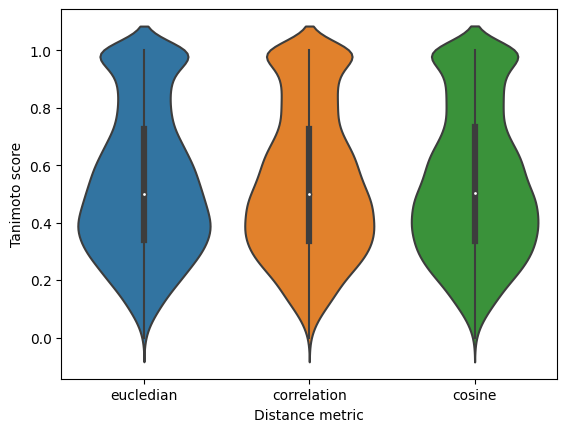

In [29]:
# violin plot

palette = sns.color_palette("bright")
#for i, tan in enumerate(tanis):
sns.violinplot(df)
#plt.legend(labels=metrics, loc='upper right', fontsize=12)
plt.xlabel('Distance metric')
plt.ylabel('Tanimoto score')
plt.show()

In [19]:
# group queries based on tanimoto scores with their top hit
category = []
for tani in sdl_mol_tanis:
    if tani <= 0.5:
        category.append('Low (tanimoto=<0.5)')
    elif 0.5 < tani < 0.8:
        category.append('Medium (0.5<tanimoto<0.8)')
    elif tani >= 0.8:
        category.append('High (tanimoto>=0.8)')
        
len(category)   

8290

In [20]:
category.count('High (tanimoto>=0.8)')

1712

In [21]:
# create a column in the df with category; also append the tanis to be sure they were well categorised
test_df['category'] = category
test_df['tanimoto'] = sdl_mol_tanis
test_df.head()


# test_common_ichi['category'] = category
# test_common_ichi['tanimoto'] = sdl_common_tanis
# test_common_ichi.tail()
#no idea of pandas warnings; but if it works dont touch :)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,category,tanimoto
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",Low (tanimoto=<0.5),0.3434
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",Medium (0.5<tanimoto<0.8),0.5405
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.06586338409618886, 0.942967588380739, -1.8...","[-0.20775599360011476, 0.7636143826119569, -1....","[-2.7716846, 0.6372789, -0.17924559, 0.3081886...","[-2.6338186, 0.40164477, -0.020541228, 0.06371...",High (tanimoto>=0.8),0.8622
14421,C1OC2=C(O1)C=C(C=C2)C3=COC4=C(C3=O)C=CC(=C4)O,KNJNBKINYHZUGC-UHFFFAOYSA-N,KNJNBKINYHZUGC,spec_id12744,"[-2.8919476279177254, 7.136436073237354, -11.3...","[0.0, 10.869701385498047, 0.0, 0.9871315956115...","[1.584554, -2.3259673, -3.662932, 4.6133733, -...",Isoflavonoids,"[-0.28901973200670295, -0.3118134545305635, -0...","[-0.4108115967805857, -0.1128494291565022, -0....","[-1.6638566, -0.14555125, -0.07093884, 0.05283...","[-2.1585412, -0.0425117, -0.9576257, 0.1188292...",High (tanimoto>=0.8),0.8596
24733,O=C(OC1C(OC(OCCC2=CC=C(O)C(O)=C2)C(OC(=O)C)C1O...,ALERZNQPBWWLMW-UHFFFAOYSA-N,ALERZNQPBWWLMW,spec_id23060,"[-4.41229641164563, -6.063199486461368, 5.2722...","[2.8529367446899414, 9.61679458618164, 15.8730...","[1.791454, -10.160973, -14.062275, 4.4526644, ...",Cinnamic acids and derivatives,"[-0.4426021969600858, 1.809169159153108, -1.36...","[-0.045717320727094835, 0.8496795834228216, -1...","[0.23103917, 1.7803116, 0.6962889, -0.04533320...","[1.5970452, 0.87056667, 0.012284648, 0.0887110...",Low (tanimoto=<0.5),0.4717


In [22]:
x = np.array([i for i in test_df['sdl_768_z1']])

y = np.array([i for i in test_df['sdl_768_z2']])

In [23]:
tsne = TSNE(n_components=2, 
            verbose=0, 
            perplexity=10, # assuming these is related to neighbours
            n_iter=1000,
           init = 'pca',
           learning_rate = 'auto'
           )

x_transformed = tsne.fit_transform(x)
y_transformed = tsne.fit_transform(y)


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


No handles with labels found to put in legend.


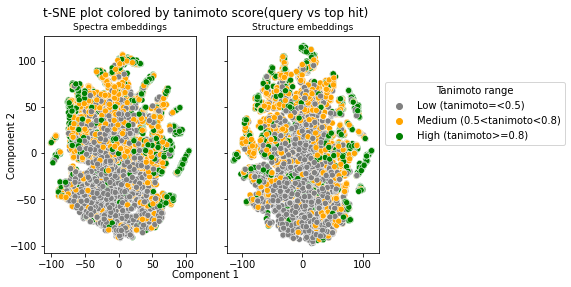

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_transformed[:,0],
           y=x_transformed[:,1], hue = category, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=y_transformed[:,0],
           y=y_transformed[:,1], hue = category,
                palette = ['grey', 'orange','green'],
                ax=ax2)
f.suptitle('t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('Spectra embeddings', fontsize=9)
ax2.set_title('Structure embeddings', fontsize=9)
#plt.legend(labels=category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

#ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
ax2.legend(handles, labels, loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()

#### Investigate which molecules are enriched in the high Tanimoto regions

In [26]:
# select classes under each category
high_class = test_df.loc[test_df['category'] == 'High (tanimoto>=0.8)']
medium_class = test_df.loc[test_df['category'] == 'Medium (0.5<tanimoto<0.8)']
low_class = test_df.loc[test_df['category'] == 'Low (tanimoto=<0.5)']
print(len(high_class),len(medium_class),len(low_class))

1712 2465 4113


### Fisher_exact test

This follows scipy.stats.fisher_exact test [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)

1. High scoring queries

In [27]:
yes_no = []
for score in test_df['category']:
    if score == 'High (tanimoto>=0.8)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group'] = [x for x in yes_no] 

In [28]:
table_df = test_df[['cf_class', 'group']]
table_df.shape

(8290, 2)

In [29]:
#creat contigency table for all classes
levels = [x for x in table_df['group']] # yes if high tanimoto, no if else
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count = crosstab(cf_class, levels)
count.shape

(250, 2)

In [30]:
xlevels

array(['no', 'yes'], dtype='<U3')

In [31]:
count[:5] #column1 == not high score,column2 == yes success(high score)

array([[ 2,  1],
       [18,  0],
       [ 2,  0],
       [ 2,  2],
       [ 1,  0]])

In [45]:
# fisher_eaxct test
metric = 'cos'
pval = []
M = count.sum()
class_total =[]
class_identified = []
success_rate = []
unsuccess_rate= [] # running out of variable names :)
all_success = []
all_unsuccess = []
for i in range(len(count)):
    x = count[i][1] # success for one class 
    n = count[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count[:,1].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) # two-sided ?
    pval.append(p)
    success_rate.append((x/n))
    unsuccess_rate.append((n_x/n))
    class_total.append(n)
    all_success.append((x/N))
    all_unsuccess.append((n_x/(M-N)))
    class_identified.append(x)

#creat df
high_enriched_df = pd.DataFrame({'cf_class':[x for x in xclass],
                            'pvalue':[x for x in pval],
                            'class_total': [x for x in class_total],
                            '#_high_tanimoto': [x for x in class_identified],
                           'ratio_class_high_tanimoto': [x for x in success_rate],
                           'ratio_class_not_high_tanimoto': [x for x in unsuccess_rate],
                            'high_tanimoto': [x for x in all_success],
                            'not_high_tanimoto': [x for x in all_unsuccess]}
                            
                          )

high_enriched_df = high_enriched_df.sort_values(['pvalue','ratio_class_high_tanimoto'],
                                                ascending = [True, False])
Files(f'./sdl_768_15_dims/high_scoring_hits_by_{metric}_distance').write_to_file(high_enriched_df)
high_enriched_df.head(10)

,cf_class,pvalue,class_total,#_high_tanimoto,ratio_class_high_tanimoto,ratio_class_not_high_tanimoto,high_tanimoto,not_high_tanimoto
99,Glycerophospholipids,8.473542e-56,136,113,0.830882,0.169118,0.066005,0.003497
98,Glycerolipids,1.729303e-45,94,83,0.882979,0.117021,0.048481,0.001672
28,Benzene and substituted derivatives,6.661315e-36,729,36,0.049383,0.950617,0.021028,0.105351
249,nan,2.381089e-33,265,142,0.535849,0.464151,0.082944,0.018699
90,Flavonoids,1.215545e-24,441,183,0.414966,0.585034,0.106893,0.039222
13,Aporphines,6.723280e-09,42,26,0.619048,0.380952,0.015187,0.002432
212,Sphingolipids,9.831863e-08,33,21,0.636364,0.363636,0.012266,0.001824
135,Macroline alkaloids,3.265486e-06,8,8,1.000000,0.000000,0.004673,0.000000
165,Peptidomimetics,4.683375e-05,153,53,0.346405,0.653595,0.030958,0.015202
138,Naphthalenes,5.530023e-04,36,0,0.000000,1.000000,0.000000,0.005473


2. Low scoring queries

In [36]:
#categories
yes_no = []
for score in test_df['category']:
    if score == 'Low (tanimoto=<0.5)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group_low'] = [x for x in yes_no] 
table_df = test_df[['cf_class', 'group_low']]

In [37]:
#create contigency table for the low scoring queries ::: will create one function for this

levels = [x for x in table_df['group_low']] # yes if high tanimoto, no if else
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count_low = crosstab(cf_class, levels)
count_low.shape

(250, 2)

In [38]:
xlevels

array(['no', 'yes'], dtype='<U3')

In [39]:
count_low[:5] # col 1 not low score; col 2 low score

array([[ 3,  0],
       [13,  5],
       [ 0,  2],
       [ 2,  2],
       [ 0,  1]])

In [40]:
# fisher_eaxct test for the low scoring queries

pval = []
M = count.sum()
class_total =[]
class_low = []
success_rate = []
unsuccess_rate= [] # running out of variable names :)
all_success = []
all_unsuccess = []
for i in range(len(count_low)):
    x = count_low[i][1] # success for one class 
    n = count_low[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count_low[:,1].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) 
    pval.append(p)
    success_rate.append((x/n))
    unsuccess_rate.append((n_x/n))
    class_total.append(n)
    class_low.append(x)
    all_success.append((x/N))
    all_unsuccess.append((n_x/(M-N)))

#create low enriched df
low_enriched_df = pd.DataFrame({'cf_class':[x for x in xclass],
                            'pvalue':[x for x in pval],
                            'class_total': [x for x in class_total],
                            '#_low_tanimoto': [x for x in class_low],
                           'ratio_class_low_tanimoto': [x for x in success_rate],
                           'ratio_class_not_low_tanimoto': [x for x in unsuccess_rate],
                            'ratio_all_low_tanimoto': [x for x in all_success],
                            'ratio_all_not_low_tanimoto': [x for x in all_unsuccess]}
                          )

low_enriched_df = low_enriched_df.sort_values(['pvalue','ratio_class_low_tanimoto'],
                                                ascending = [True, False])
low_enriched_df.head(10)

Files(f'./sdl_768_15_dims/low_scoring_hits_by_{metric}_distance').write_to_file(low_enriched_df)

In [49]:
#drop some columns that arent useful in heatmap
new_df_high = high_enriched_df.drop(columns=['cf_class', 
                                             'class_total',
                                             'pvalue',
                                             'ratio_class_high_tanimoto',
                                             'ratio_class_not_high_tanimoto',
                                             '#_high_tanimoto'])
new_df_low = low_enriched_df.drop(columns=['cf_class', 'class_total', '#_low_tanimoto'])

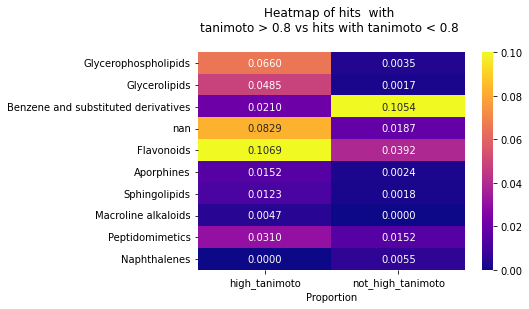

In [59]:
lab = [x for x in high_enriched_df['cf_class'].head(10)]
sns.heatmap(new_df_high.head(10), yticklabels = lab, vmin=0, vmax=0.1,cmap="plasma",
          annot=True, fmt=".4f")
plt.title('Heatmap of hits  with \ntanimoto > 0.8 vs hits with tanimoto < 0.8 \n')
plt.savefig(f'./sdl_768_15_dims/heatmap_high_scoring_hits_by_{metric}_distance',bbox_inches = 'tight')
plt.xlabel('Proportion')
plt.show()

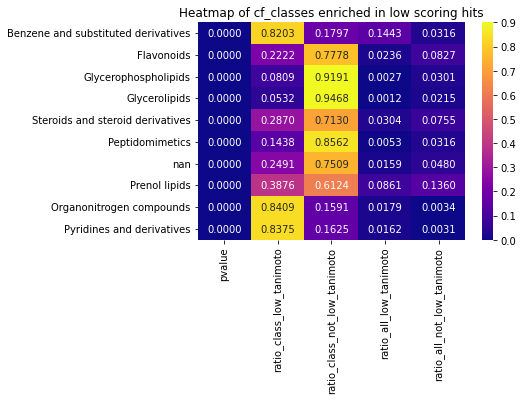

In [159]:
# for discussion the above captures enough info
lab = [x for x in low_enriched_df['cf_class'].head(10)]
sns.heatmap(new_df_low.head(10), yticklabels = lab, vmin=0, vmax=0.9,cmap="plasma",
          annot=True, fmt=".4f")
plt.title('Heatmap of cf_classes enriched in low scoring hits')
plt.savefig(f'./sdl_768_15_dims/heatmap_low_scoring_hits_by_{metric}_distance',bbox_inches = 'tight')
plt.show()

#### Draw a few random Mols from Glyecrolipids

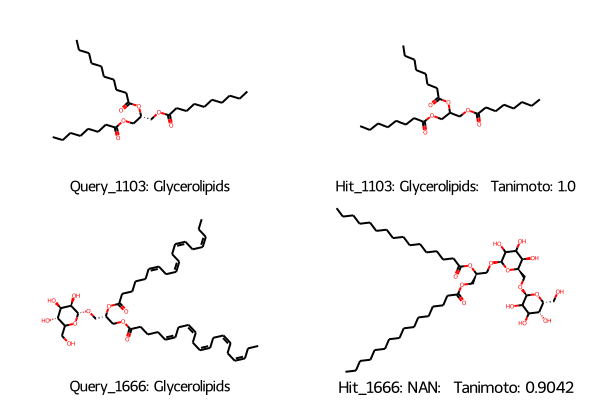

In [141]:
sdl_glycerols_query_mols, sdl_glycerols_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Glycerolipids'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_glycerols_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_glycerols_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_glycerols_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)



#### Draw a few random Mols from Glyecrophospholipids

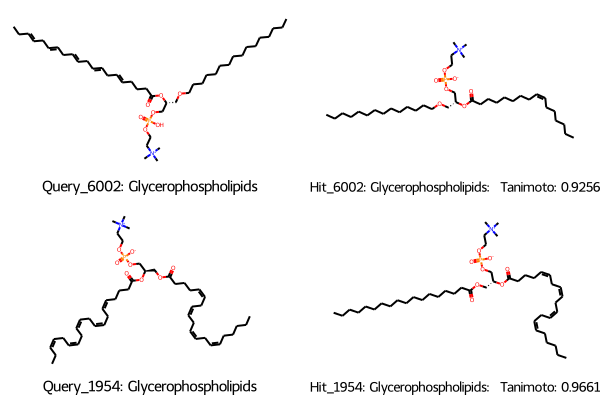

In [132]:
sdl_glyphospho_query_mols, sdl_glyphospho_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Glycerophospholipids'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_glyphospho_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_glyphospho_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_glyphospho_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)


#### Draw a few random Mols from Benzenes and Derivatives

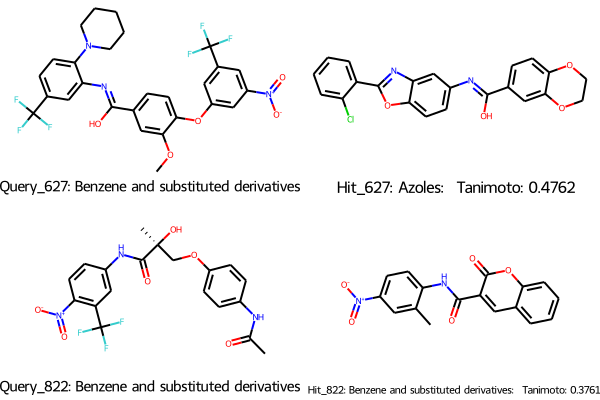

In [138]:
sdl_benzenes_query_mols, sdl_benzenes_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Benzene and substituted derivatives'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_benzenes_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_benzenes_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_benzenes_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)


#### Never mind the codes below; you have reached the end of important codes

In [310]:
#random drawing for top 5 hits

# #randomly pick a query
# keys = random.sample(test_cca_corr_tanimotos.keys(),5)
# sample_dict = {key: test_cca_corr_tanimotos[key] for key in keys}

# #draw select top 5 hits
# all_mols = []
# #scores = []
# mol_classes = []
# #os.chdir('../compounds')
# for query_index, values in tqdm(sample_dict.items()):
#     top_hits = np.sort(values)[:5]
#     tanimotos = []
    
#     #draw the query
    
#     query_smile= val_df['smiles'].iloc[query_index]
#     query_class = val_df['cf_class'].iloc[query_index]
#     if type(query_class) == float:
#         query_class = 'NAN'
#         classes = [f'Query:\t{query_class}',]
#     classes = [f'QUERY:\t{query_class}',]
#     query = Chem.MolFromSmiles(query_smile)
#     #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
#     #Draw.MolsToGridImage(query)
#     #draw top 5 hits
#     subjects = [query,]
#     for hit_index, hit in enumerate(top_hits):
#         subject_index = values.index(hit)
#         subject_smile = train_df['smiles'].iloc[subject_index]
        
        
#         subject = Chem.MolFromSmiles(subject_smile)
#         subjects.append(subject)
#         #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
#         cl = train_df['cf_class'].iloc[subject_index]
#         if type(cl) == float:
#             cl = 'NAN'
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         else:
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         #check tanimotos for the random selections
#         tanimotos.append(tanimoto(query_smile,subject_smile))
#    # scores.append([(query_index,query_class),tanimotos])
#     all_mols.append(subjects)
#     mol_classes.append(classes)


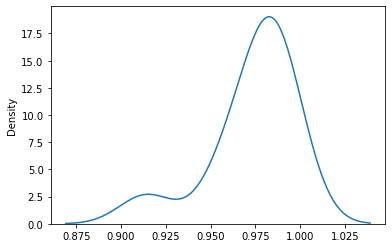

In [312]:
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])